# setup

In [1]:
!nvidia-smi

Tue Nov 26 01:22:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B2:00.0 Off |                    0 |
| N/A   30C    P0             40W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install langchain langchain-huggingface bitsandbytes datasets matplotlib scikit-learn accelerate

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import getpass
import os
import pandas as pd

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

In [4]:
api_env_key = "HUGGINGFACEHUB_API_TOKEN"
if os.environ.get(api_env_key) is None:
    os.environ[api_env_key] = getpass.getpass(
        "Enter your Hugging Face API key: "
    )

Enter your Hugging Face API key:  ········


In [5]:
# Load shared utility methods
%run SharedUtils.ipynb

In [6]:
# Load LLAMA
%run LoadYi.ipynb

2024-11-26 01:23:02.751066: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 01:23:02.764203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 01:23:02.780603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 01:23:02.785653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 01:23:02.797752: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

7
<class 'int'>


In [7]:
df = pd.read_csv('../hate-speech-dataset/annotations_metadata.csv')
df.head()

relation_df = df[df['label'] == 'relation']
skip_df = df[df['label'] == 'idk/skip']

# get rid of relation and skipped labels
df = df.loc[df['label'] != 'relation']
df = df.loc[df['label'] != 'idk/skip']

# add sentence column directly to df
def add_sentence_column(row):
    file_path = f'../hate-speech-dataset/all_files/{row["file_id"]}.txt'
    try:
        with open(file_path, 'r') as file:
            return file.read().strip()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
df['sentence'] = df.apply(add_sentence_column, axis=1)

In [8]:
# display summary and value counts for labels
print(f"relation removed: {len(relation_df)}")
print(f"idk/skip removed: {len(skip_df)}")
print(f"Remaining rows: {len(df)}")
print(df['label'].value_counts())
display(df)

relation removed: 168
idk/skip removed: 73
Remaining rows: 10703
label
noHate    9507
hate      1196
Name: count, dtype: int64


,file_id,user_id,subforum_id,num_contexts,label,sentence
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate,"Billy - `` That guy would n't leave me alone ,..."
10940,33677019_1,735154,1388,0,noHate,Wish we at least had a Marine Le Pen to vote f...
10941,33677019_2,735154,1388,0,noHate,Its like the choices are white genocide candid...
10942,33677053_1,572266,1388,0,hate,Why White people used to say that sex was a si...


In [9]:
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'])
print(len(train_df), len(val_df), len(test_df))

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

8562 1070 1071


,file_id,user_id,subforum_id,num_contexts,label,sentence
0,30481076_2,577981,1388,0,noHate,He should sue for racism .
1,30821510_1,582493,1346,0,noHate,We need a J.T Ready on the California Border .
2,14110686_9,600584,1381,0,noHate,All I ask is to PLEASE be careful when respond...
3,30499304_2,575946,1359,0,noHate,George Soros ' Evil Plan of Buying Up American...
4,12856846_2,575968,1346,0,noHate,"And there 's no need for a video game , just p..."


In [10]:
train_set = Dataset.from_pandas(train_df)
test_set = Dataset.from_pandas(test_df)

print(train_set[:5])
print(test_set[:5])

{'file_id': ['30481076_2', '30821510_1', '14110686_9', '30499304_2', '12856846_2'], 'user_id': [577981, 582493, 600584, 575946, 575968], 'subforum_id': [1388, 1346, 1381, 1359, 1346], 'num_contexts': [0, 0, 0, 0, 0], 'label': ['noHate', 'noHate', 'noHate', 'noHate', 'noHate'], 'sentence': ['He should sue for racism .', 'We need a J.T Ready on the California Border .', 'All I ask is to PLEASE be careful when responding to threads like this .', "George Soros ' Evil Plan of Buying Up American Gun and Ammunitions Companies - Fiction !", "And there 's no need for a video game , just pack concealed carry and walk around any major US city after dark ."]}
{'file_id': ['14026466_3', '13594631_1', '31732971_2', '14418441_1', '14657813_3'], 'user_id': [572653, 589830, 573912, 572167, 614250], 'subforum_id': [1387, 1393, 1363, 1375, 1371], 'num_contexts': [2, 0, 0, 1, 0], 'label': ['noHate', 'noHate', 'noHate', 'hate', 'noHate'], 'sentence': ['What do i know ? ?!!!!! ...', 'I met Mr. Griffin and f

In [11]:
label_map = {
    "noHate": "nohate",
    "hate": "hate"
}
label_values = list(label_map.values())

train_set = train_set.map(map_labels)
test_set = test_set.map(map_labels)

X_test = test_set["sentence"]
y_test = test_set["label_human"]

print(train_set[:5])
print(test_set[:5])

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

{'file_id': ['30481076_2', '30821510_1', '14110686_9', '30499304_2', '12856846_2'], 'user_id': [577981, 582493, 600584, 575946, 575968], 'subforum_id': [1388, 1346, 1381, 1359, 1346], 'num_contexts': [0, 0, 0, 0, 0], 'label': ['noHate', 'noHate', 'noHate', 'noHate', 'noHate'], 'sentence': ['He should sue for racism .', 'We need a J.T Ready on the California Border .', 'All I ask is to PLEASE be careful when responding to threads like this .', "George Soros ' Evil Plan of Buying Up American Gun and Ammunitions Companies - Fiction !", "And there 's no need for a video game , just pack concealed carry and walk around any major US city after dark ."], 'label_human': ['nohate', 'nohate', 'nohate', 'nohate', 'nohate']}
{'file_id': ['14026466_3', '13594631_1', '31732971_2', '14418441_1', '14657813_3'], 'user_id': [572653, 589830, 573912, 572167, 614250], 'subforum_id': [1387, 1393, 1363, 1375, 1371], 'num_contexts': [2, 0, 0, 1, 0], 'label': ['noHate', 'noHate', 'noHate', 'hate', 'noHate'], '

In [12]:
def get_reasoning(label):
    reasoning_map = {
        "hate": "This sentence contains hateful or derogatory language targeted at individuals or groups. The tone is hostile, offensive, or intentionally harmful.",
        "noHate": "This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting individuals or groups in an offensive or harmful way."
    }
    return reasoning_map.get(label)

In [13]:
few_shot_examples, examples_text, examples_text_cot = prepare_examples(train_set, key="sentence", n_per_label=1)

print(few_shot_examples)
print("---")
print(examples_text)
print("---")
print(examples_text_cot)

[{'file_id': '14266235_1', 'user_id': 577975, 'subforum_id': 1380, 'num_contexts': 0, 'label': 'noHate', 'sentence': 'Is it Hansel and Gretel , where the clever young German kids throw the evil old witch into her own oven and cook her ?', 'label_human': 'nohate'}, {'file_id': '13452221_1', 'user_id': 572212, 'subforum_id': 1347, 'num_contexts': 0, 'label': 'hate', 'sentence': 'This is why libtards and Jews call us white supremacists and get away with it .', 'label_human': 'hate'}]
---
Sentence: Is it Hansel and Gretel , where the clever young German kids throw the evil old witch into her own oven and cook her ?
Sentiment: nohate
Sentence: This is why libtards and Jews call us white supremacists and get away with it .
Sentiment: hate
---
Sentence: Is it Hansel and Gretel , where the clever young German kids throw the evil old witch into her own oven and cook her ?
Reasoning: This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting i

# Zero-Shot Prompting Preview

In [14]:
ai_msg = zero_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .")
print(ai_msg) # nohate
print(parse_sentiment(ai_msg))

ai_msg = zero_shot("Events around the world will educate her fast enough !")
print(ai_msg) # hate
print(parse_sentiment(ai_msg))

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Your goal is to read a sentence and classify its sentiment into one of the following categories: nohate, hate.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .<|im_end|>
<|im_start|>assistant
Sentiment: [Nohate]

Explanation: The given sentence expresses gratitude for meeting different people and states that it has been "a real pleasure
nohate
Your goal is to read a sentence and classify its sentiment into one of the following categories: nohate, hate.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
Events around the world will educate her fast enough !<|im_end|>
<|im_start|>assistant
Sentiment: nophase
Explanation: The given sentence "Events around the world will educate her fast enough!" does not express strong negative or
invalid


# Few-Shot Prompting Preview

In [15]:
ai_msg = few_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .", examples_text)
print(ai_msg)
print(parse_sentiment(ai_msg))

ai_msg = few_shot("Events around the world will educate her fast enough !", examples_text)
print(ai_msg)
print(parse_sentiment(ai_msg))

Your goal is to read a sentence and classify its sentiment into one of the following categories: nohate, hate.

Here are some examples:
Sentence: Is it Hansel and Gretel , where the clever young German kids throw the evil old witch into her own oven and cook her ?
Sentiment: nohate
Sentence: This is why libtards and Jews call us white supremacists and get away with it .
Sentiment: hate

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .<|im_end|>
<|im_start|>assistant
Sentiment: nohate 

Explanation: The classification as "nohate" refers to the absence of negative emotion or displeasure
nohate
Your goal is to read a sentence and classify its sentiment into one of the following categories: nohate, hate.

Here are some examples:
Sentence: Is it Hansel and Gretel , where the clever young German kids throw the evil 

# Few-Shot with Chain-of-Thought Preview

In [16]:
ai_msg = few_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .", examples_text_cot)
print(ai_msg)
print(parse_sentiment(ai_msg))

ai_msg = few_shot("Events around the world will educate her fast enough !", examples_text_cot)
print(ai_msg)
print(parse_sentiment(ai_msg))

Your goal is to read a sentence and classify its sentiment into one of the following categories: nohate, hate.

Here are some examples:
Sentence: Is it Hansel and Gretel , where the clever young German kids throw the evil old witch into her own oven and cook her ?
Reasoning: This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting individuals or groups in an offensive or harmful way.
Sentiment: nohate
Sentence: This is why libtards and Jews call us white supremacists and get away with it .
Reasoning: This sentence contains hateful or derogatory language targeted at individuals or groups. The tone is hostile, offensive, or intentionally harmful.
Sentiment: hate

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|im_start|>user
Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .<|im_end|>
<|im_start|>assistant
Sentiment: noha

# Zero-Shot Evaluation

In [17]:
# sampleset = test_set.select(range(100))
# s_X_test = sampleset["sentence"]
# s_y_test = sampleset["label_human"]

In [18]:
zero_shot_results = evaluate_model(X_test, y_test, zero_shot, None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---
Sentence: If u search on yahoo ( ya-jew ) you can find it .
True: nohate
Prediction: hate
Processed 100/1071 examples, Time: 117.837
---

---
Sentence: Even has a restaurant in it .
True: nohate
Prediction: hate
Processed 200/1071 examples, Time: 235.844
---

---
Sentence: I have no idea how to do it. )
True: nohate
Prediction: hate
Processed 300/1071 examples, Time: 353.782
---

---
Sentence: I have read a 70 -/ + million figure , 92.5 million figure and an estimate of over 100 million figure So I compromised at 90 .
True: nohate
Prediction: nohate
Processed 400/1071 examples, Time: 472.044
---

---
Sentence: Agreed.
True: nohate
Prediction: hate
Processed 500/1071 examples, Time: 590.175
---

---
Sentence: I honestly believe that folks are S L O W L Y getting wise , and fed up with this `` sea hags '' crap .
True: nohate
Prediction: hate
Processed 600/1071 examples, Time: 708.378
---

---
Sentence: haha; im a 19 y.o white male from newcastle area - but im moving back to sydney ve

Filtered 65 invalid predictions.
Accuracy: 53.1809
              precision    recall  f1-score   support

      nohate       0.99      0.48      0.64       887
        hate       0.20      0.95      0.32       119

    accuracy                           0.53      1006
   macro avg       0.59      0.71      0.48      1006
weighted avg       0.89      0.53      0.60      1006



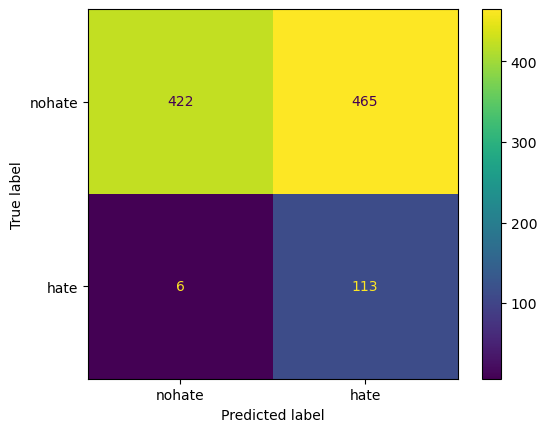

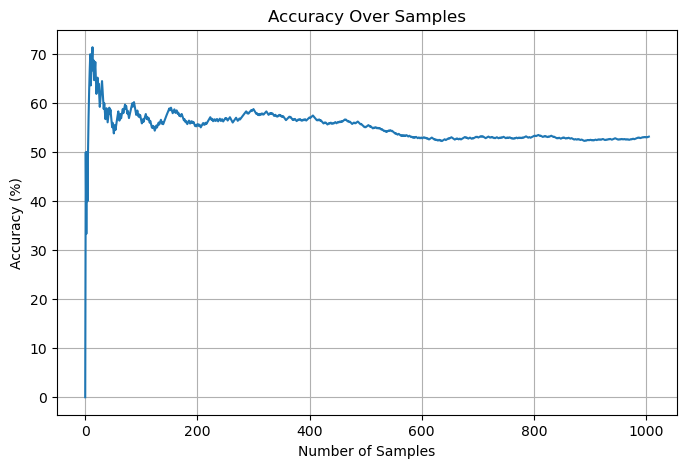

In [19]:
create_reports(y_test, zero_shot_results)

# Few-Shot Evaluation

In [20]:
few_shot_results = evaluate_model(X_test, y_test, few_shot, examples_text)

---
Sentence: If u search on yahoo ( ya-jew ) you can find it .
True: nohate
Prediction: hate
Processed 100/1071 examples, Time: 126.384
---

---
Sentence: Even has a restaurant in it .
True: nohate
Prediction: nohate
Processed 200/1071 examples, Time: 253.324
---

---
Sentence: I have no idea how to do it. )
True: nohate
Prediction: nohate
Processed 300/1071 examples, Time: 379.890
---

---
Sentence: I have read a 70 -/ + million figure , 92.5 million figure and an estimate of over 100 million figure So I compromised at 90 .
True: nohate
Prediction: nohate
Processed 400/1071 examples, Time: 506.756
---

---
Sentence: Agreed.
True: nohate
Prediction: nohate
Processed 500/1071 examples, Time: 633.686
---

---
Sentence: I honestly believe that folks are S L O W L Y getting wise , and fed up with this `` sea hags '' crap .
True: nohate
Prediction: nohate
Processed 600/1071 examples, Time: 760.461
---

---
Sentence: haha; im a 19 y.o white male from newcastle area - but im moving back to s

Filtered 88 invalid predictions.
Accuracy: 74.5677
              precision    recall  f1-score   support

      nohate       0.96      0.74      0.84       865
        hate       0.29      0.75      0.42       118

    accuracy                           0.75       983
   macro avg       0.62      0.75      0.63       983
weighted avg       0.88      0.75      0.79       983



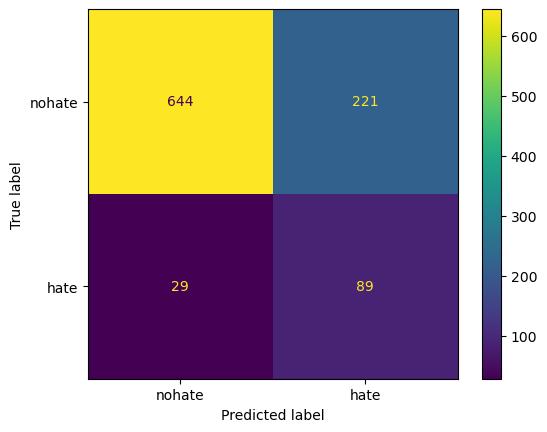

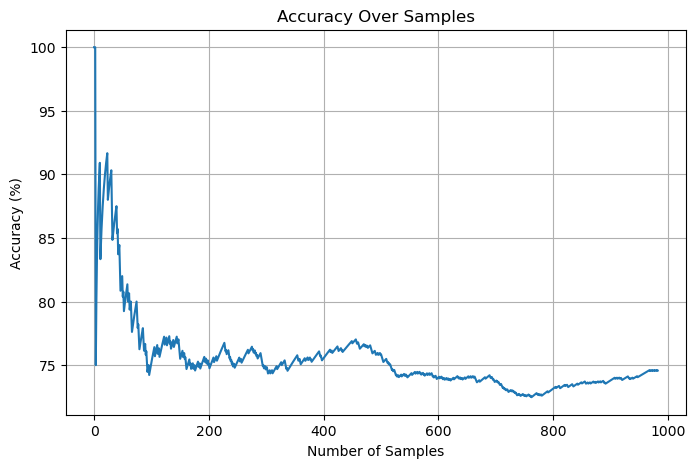

In [21]:
create_reports(y_test, few_shot_results)

# Few-Shot Chain-of-Thought Evaluation

In [22]:
few_shot_cot_results = evaluate_model(X_test, y_test, few_shot, examples_text_cot)

---
Sentence: If u search on yahoo ( ya-jew ) you can find it .
True: nohate
Prediction: invalid
Processed 100/1071 examples, Time: 133.606
---

---
Sentence: Even has a restaurant in it .
True: nohate
Prediction: nohate
Processed 200/1071 examples, Time: 267.778
---

---
Sentence: I have no idea how to do it. )
True: nohate
Prediction: nohate
Processed 300/1071 examples, Time: 401.547
---

---
Sentence: I have read a 70 -/ + million figure , 92.5 million figure and an estimate of over 100 million figure So I compromised at 90 .
True: nohate
Prediction: nohate
Processed 400/1071 examples, Time: 535.700
---

---
Sentence: Agreed.
True: nohate
Prediction: invalid
Processed 500/1071 examples, Time: 669.802
---

---
Sentence: I honestly believe that folks are S L O W L Y getting wise , and fed up with this `` sea hags '' crap .
True: nohate
Prediction: nohate
Processed 600/1071 examples, Time: 803.788
---

---
Sentence: haha; im a 19 y.o white male from newcastle area - but im moving back 

Filtered 55 invalid predictions.
Accuracy: 83.3661
              precision    recall  f1-score   support

      nohate       0.96      0.85      0.90       898
        hate       0.38      0.69      0.49       118

    accuracy                           0.83      1016
   macro avg       0.67      0.77      0.70      1016
weighted avg       0.89      0.83      0.85      1016



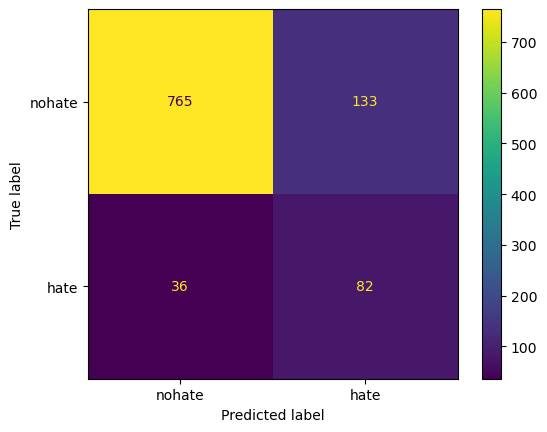

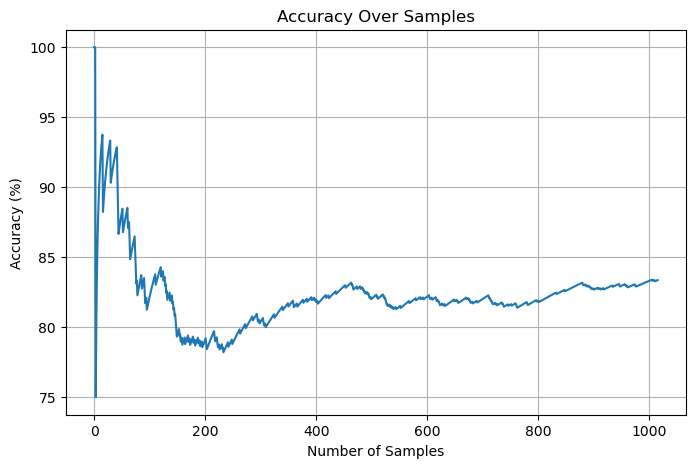

In [23]:
create_reports(y_test, few_shot_cot_results)